# LAB 1 - Wykrywanie krawędzi metodą Canny'jego
Autor: Błażej Nowicki

In [1]:
import torch
import torch.nn as nn
import numpy as np
from PIL import Image, ImageOps
import torchvision.transforms as T

In [2]:
def preview(tensor):
    preview = tensor.squeeze(0)
    return T.ToPILImage()(preview) 

def save(pil, name):
    return pil.save(f'images/{name}.png', "PNG")

### Load image


In [3]:
img = original =  Image.open("sample.jpg")
img
save(img, "0_original")

In [4]:
img = T.ToTensor()(img)
img = img.unsqueeze(0)  # == reshape(1, 2, w, h)

### Convert RGB to grayscale


In [5]:
# 0.299 ∙ Red + 0.587 ∙ Green + 0.114 ∙ Blue.
def rgb_to_grayscale_kernel():
    kernel = torch.tensor([0.299, 0.587, 0.114], dtype=torch.float32)
    return kernel.reshape((1, 3, 1, 1))

In [6]:
kernel = rgb_to_grayscale_kernel()
rgb_to_gray_conv = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=1, bias=False)
rgb_to_gray_conv.weight = nn.Parameter(kernel)

In [7]:
img = rgb_to_gray_conv(img)

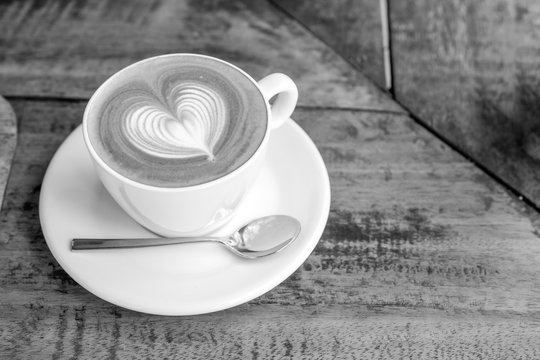

In [8]:
pil = preview(img)
save(pil, "1_gray_scale")
pil

### Apply average pooling

Do wykrywania krawędzi zastosujemy MaxPool ponieważ nie rozmazuje krawędzi tak jak AvgPool. Przy pullingu gdzie kernel size = 2 różnica pomiędzy tymi dwoma jest prawie niezauważalna.

torch.Size([1, 1, 360, 540])


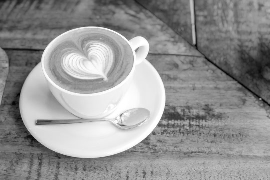

In [9]:
avg_poll_conv = nn.MaxPool2d(kernel_size=2)
print(img.shape)
img = avg_poll_conv(img)

pil = preview(img)
save(pil, "2_resized")
pil

### Apply gaussian blur

In [10]:
def gaussian_kernel(size, sigma=1):
    assert size % 2 == 1, "Kernel size must be an odd number"
    half = int(size) // 2
    x, y = np.mgrid[-half : half + 1, -half : half + 1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g = np.exp(-((x**2 + y**2) / (2.0 * sigma**2))) * normal
    return torch.tensor(g, dtype=torch.float32).reshape(1, 1, size, size)

In [11]:
blur_size = 21
kernel = gaussian_kernel(blur_size)
blur_conv = nn.Conv2d(
    in_channels=1, out_channels=1, kernel_size=kernel.shape, bias=False
)
blur_conv.weight = nn.Parameter(kernel)
img = blur_conv(img)

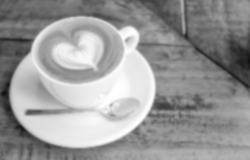

In [12]:
pil = preview(img)
save(pil, "3_blured")
pil

### Calculate gradient

In [13]:
def gradient_kernel():
    kernel = torch.tensor(
        [
            [[[[1, 2, 1], [0, 0, 0], [-1, -2, -1]]]],
            [[[[1, 0, -1], [2, 0, -2], [1, 0, -1]]]],
        ],
        dtype=torch.float32,
    )
    return kernel.reshape(2, 1, 3, 3)

In [14]:
kernel = gradient_kernel()
print(kernel)
gradient_conv = nn.Conv2d(
    in_channels=1, out_channels=2, kernel_size=3, bias=False, #stride=(1, 1, 1), padding=(0, 0, 0), dilation=(0, 0, 0)
)
gradient_conv.weight = nn.Parameter(kernel)
img = gradient_conv(img)



tensor([[[[ 1.,  2.,  1.],
          [ 0.,  0.,  0.],
          [-1., -2., -1.]]],


        [[[ 1.,  0., -1.],
          [ 2.,  0., -2.],
          [ 1.,  0., -1.]]]])


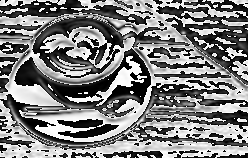

In [15]:
pil = preview(img[:, 0, :, :])
save(pil, "4_sobel_x")
pil

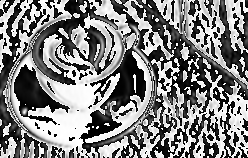

In [16]:

pil = preview(img[:, 1, :, :])
save(pil, "5_sobel_y")
pil

In [17]:
class Gradient(nn.Module):
    def forward(self, x):
        return torch.concat(
            ((torch.sqrt(torch.sum(torch.square(x), dim=1))).unsqueeze(1),
            torch.arctan(x[:, 0, :, :] / x[:, 1, :, :]).unsqueeze(1)),
            dim=1,
        )

In [18]:
gradient_layer = Gradient()
img = gradient_layer(img)
img.shape


torch.Size([1, 2, 158, 248])

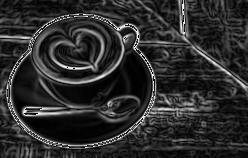

In [19]:
pil = preview(img[:, 0, :, :])
save(pil, "6_gradient_value")
pil

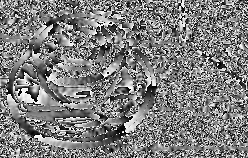

In [20]:
pil = preview(img[:, 1, :, :])
save(pil, "7_gradient_direction")
pil

In [21]:
test = img
test.shape

torch.Size([1, 2, 158, 248])

In [22]:
class NonMaxSuppression(nn.Module):
    def forward(self, img):
        M, N = img.shape[-2:]

        D = img[0, 1, :, :]
        img = img[0, 0, :, :]
        # return img

        Z = np.zeros((M, N), dtype=np.float32)
        angle = D * 180.0 / np.pi
        angle[angle < 0] += 180
        for i in range(1, M - 1):
            for j in range(1, N - 1):
                try:
                    q = float("inf")
                    r = float("inf")
                    # angle 0
                    if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                        q = img[i, j + 1]
                        r = img[i, j - 1]
                    # angle 45
                    elif 22.5 <= angle[i, j] < 67.5:
                        q = img[i + 1, j - 1]
                        r = img[i - 1, j + 1]
                    # angle 90
                    elif 67.5 <= angle[i, j] < 112.5:
                        q = img[i + 1, j]
                        r = img[i - 1, j]
                    # angle 135
                    elif 112.5 <= angle[i, j] < 157.5:
                        q = img[i - 1, j - 1]
                        r = img[i + 1, j + 1]
                    if (img[i, j] >= q) and (img[i, j] >= r):
                        Z[i, j] = img[i, j]
                    else:
                        Z[i, j] = 0
                except IndexError as e:
                    pass

        return torch.tensor(Z, dtype=torch.float32).reshape(
            1, 1, Z.shape[-2], Z.shape[-1]
        )

In [23]:
non_max_suppression_layer = NonMaxSuppression()
img = non_max_suppression_layer(img)

pil = preview(img)
save(pil, "8_non_max_suppresion")

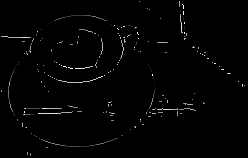

In [24]:
TRESHHOLD = 0.5

class ReLU(nn.Module):
    def forward(self, x):
        x[x < TRESHHOLD] = 0.
        return x

relu = ReLU()
img = relu(img)
final = preview(img)
save(final, "9_relu")
final


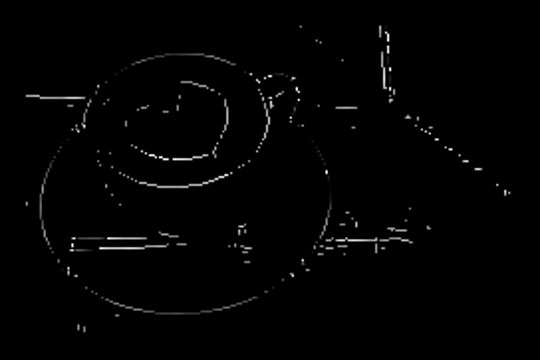

In [25]:
expanded = ImageOps.expand(final, border=12, fill="black")
resized = expanded.resize(original.size)
save(resized, "10_final_resized")
resized

Żeby krawędzie pokrywały się z orginalnym obrazkiem należy dodać marginesy na końcowy obrazek. Aleternatywnie na każdym etapie obróbki trzebaby dbać o poprawny padding, żeby filtry konwolucyjne nie zmieniały wielkości obrazu.

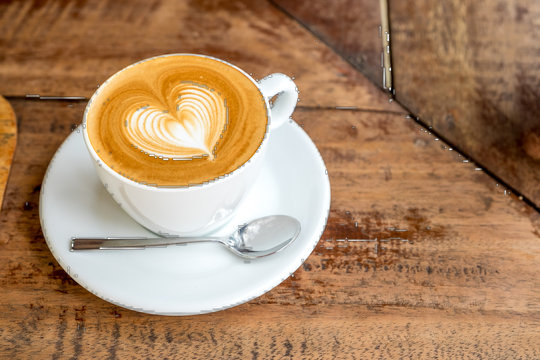

In [26]:
overlayed = original.copy()
overlayed.paste(resized, (0,0), resized)
save(overlayed, "11_overlayed")
overlayed
